# Neural Network Optimization and Tuning

You've learned how to build computational graphs in PyTorch and compute gradients. The final piece to training a network is applying the gradients to update the network parameters. In this tutorial you will learn how to implement a number of optimization techniques in PyTorch along with other tuning methods. 

In [0]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
import multiprocessing
import pdb 
%matplotlib inline
np.random.seed(2019)

np_load_old = np.load

#modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [0]:
# import importlib
# importlib.reload(np)

In [3]:

from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [0]:
# ! kaggle competitions download 11785-hw1-fall2019

In [4]:
% cd drive/My\ Drive/11-785

/content/drive/My Drive/11-785


In [5]:
! ls

11-785hw1p2-f19			 model_7_9_24.pt
11-785hw1p2-f19.tar.gz		 model_9_9_24.pt
dev_labels.npy.zip		 preds_model_10_9_24.csv
hw1p2_float16%20tar.gz		 preds_model_11_9_24.csv
hw1p2_float32.tar.gz		 preds_model_12_9_24.csv
hw1p2_sample_submission.csv.zip  preds_model_13_9_24.csv
model_10_9_24.pt		 preds_model_14_9_24.csv
model_11_9_24.pt		 preds_model_15_9_24.csv
model_12_9_24.pt		 preds_model_16_9_24.csv
model_13_9_24.pt		 preds_model_17_9_24.csv
model_14_9_24.pt		 preds_model_18_9_24.csv
model_15_9_24.pt		 preds_model_19_9_24.csv
model_16_9_24.pt		 preds_model_7_9_24.csv
model_17_9_24.pt		 preds_model_9_9_24.csv
model_18_9_24.pt		 train_labels.npy.zip
model_19_9_24.pt


In [0]:
#! tar -xvf 11-785hw1p2-f19.tar.gz

./11-785hw1p2-f19/
./11-785hw1p2-f19/dev.npy
./11-785hw1p2-f19/test.npy
./11-785hw1p2-f19/train.npy
./11-785hw1p2-f19/dev_labels.npy
./11-785hw1p2-f19/train_labels.npy


In [0]:
def pad_constant_central_pattern(x, kval_pre, kval_post):
    """
    Takes one 2-dimensional array with the constant value of padding. 
    Pads the instances with the given constant value while
    maintaining the array at the center of the padding.

    Parameters: 
    x (numpy.ndarray): 2-d numpy array.
    cval (numpy.int64): scalar quantity.
    
    Returns: 
    numpy.ndarray: 3-dimensional int numpy array, (n, m, k).
    """
    spectrogram = x
    
    # Input function dimension specification

    
    assert(x.ndim == 2)

    dim1 = x.shape[0] +  kval_pre + kval_post   # n
    dim2 = x.shape[1]

    result = np.ones((dim1,dim2))

    
    pad_above = kval_pre
    pad_below = kval_post
        
    pad_left = 0
    pad_right = 0
    
    n_add = ((pad_above, pad_below), (pad_left, pad_right))

    result = np.pad(x , pad_width=n_add , mode = 'edge') 
    

    # Assert output function dimension specification
    assert(result.shape[0] == dim1)
    assert(result.shape[1] == dim2)
    
    return result

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
from torch.utils import data
from sklearn.preprocessing import MultiLabelBinarizer

class SpectrogramTrainDataset(data.Dataset):
    """

    Arguments:
        
    """

    def __init__(self, path, X_train_name, Y_train_name, transform=None, pre_padding = 0, post_padding = 0, frame_dim = 40):
        
        self.X_train = np.load(path + X_train_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.X_test = np.load(path + X_test_name)
        
        self.Y_train = np.load(path + Y_train_name)
        #self.mlb = MultiLabelBinarizer(); 
        #self.Y_train = self.mlb.fit_transform(np.load(path + Y_train_name))
        self.pre_padding = pre_padding
        self.post_padding = post_padding
        self.frame_dim = frame_dim

    def __getitem__(self, index):
        
        utterance = self.X_train[index]
        Y = self.Y_train[index]
        
        slice_size = self.pre_padding + self.post_padding + 1
        dim1 = utterance.shape[0]
        dim2 = self.frame_dim * slice_size
        
        utterance = pad_constant_central_pattern(utterance, self.pre_padding, self.post_padding)
        
        i = random.randint(0, dim1 - 1)
        #x = torch.from_numpy(utterance[i]).type(torch.FloatTensor)
        y = Y[i]
        
        x = torch.from_numpy(utterance[i: i + slice_size].flatten()).type(torch.FloatTensor).to(self.device)
        #x = torch.from_numpy(np.random.randn(40*slice_size)).type(torch.FloatTensor)
        
        assert x.shape[0] == dim2
        
        return x, y

    def __len__(self):
        return self.X_train.shape[0]

In [0]:
class SpectrogramTestDataset(data.Dataset):
    """

    Arguments:
        
    """

    def __init__(self, path, X_test_name, transform=None, pre_padding = 5, post_padding = 5, frame_dim = 40):
        
        
        self.pre_padding = pre_padding
        self.post_padding = post_padding
        self.frame_dim = frame_dim
        
        slice_size = self.pre_padding + self.post_padding + 1
        
        test = np.load(path + X_test_name)
        dim1 = sum([t.shape[0] for t in test])
        dim2 = self.frame_dim * slice_size

        self.X_test = torch.empty(dim1, dim2).to(device)

        X_test_index = 0

        for utterance in test:

            slice_size = self.pre_padding + self.post_padding + 1
            nframes = utterance.shape[0]

            utterance = pad_constant_central_pattern(utterance, self.pre_padding, self.post_padding)

            for i in range(nframes):
                self.X_test[X_test_index] = torch.from_numpy(utterance[i: i + slice_size].flatten()).type(torch.FloatTensor).to(device)
                X_test_index += 1
        

    def __getitem__(self, index):
        
        x = self.X_test[index]
        
        return x

    def __len__(self):
        return self.X_test.shape[0]

In [0]:
train_data = SpectrogramTrainDataset('11-785hw1p2-f19/', "train.npy", "train_labels.npy", pre_padding=5, post_padding=5)


In [12]:
nworkers = multiprocessing.cpu_count()
nworkers

4

In [13]:
n_frames = 0
for utterance in train_data.X_train:
    n_frames+=utterance.shape[0]
print(n_frames)
print(n_frames/len(train_data.X_train))


weights = []
for utterance in train_data.X_train: 
    weight = utterance.shape[0] / n_frames
    weights.append(weight)



15388713
628.1107346938776


In [0]:
SpectrogramLoader = data.DataLoader(
    train_data, 
    batch_size=1000,      # Batch size
    shuffle=True,      # Shuffles the dataset at every epoch
    pin_memory=False,   # Copy data to CUDA pinned memory
                       # so that they can be transferred to the GPU very fast
    num_workers=nworkers      # Number of worker processes for loading data.
                       # If zero, use the current process (blocks until data are loaded)
                       # Otherwise fork/spawn new processes (asynchronous load)
                       # Spawning new processes can be problematic on Windows, see:
                       # https://pytorch.org/docs/stable/notes/windows.html#usage-multiprocessing
)



In [0]:
train_size = train_data.__len__()

val_size, train_size = int(0.05 * train_size), int(0.95 * train_size) # 80 / 20 train-val split
# print("val size is {}".format(val_size))
# print("train size is {}".format(train_size))

train_weights = weights[val_size: val_size+train_size] 
val_weights = weights[0:val_size]
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights), replacement = False)
val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_weights, len(val_weights), replacement = False)
# print("size of weights", len(weights))
# print("size of train weights", len(train_weights))
# print("size of val weights", len(val_weights))
# print("size of train + val weights", len(val_weights) + len(train_weights))

#test_size = test_data.test_data.shape[0]

batch_size = 5000

# Add dataset to dataloader that handles batching
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=val_sampler)


'''test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)'''

# Setup metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [16]:
class PhonemeModel(nn.Module):
    def __init__(self):
        super(PhonemeModel, self).__init__()
        self.fc1 = nn.Linear((train_data.pre_padding + train_data.post_padding + 1) * train_data.frame_dim, 1500)
        self.fc2 = nn.Linear(1500, 1500)
        self.fc3 = nn.Linear(1500, 1500)
        self.fc4 = nn.Linear(1500, 1500)
        self.fc5 = nn.Linear(1500, 1500)
        self.fc6 = nn.Linear(1500, 138)
        
        self.bn1 = nn.BatchNorm1d(1500)
    
    def forward(self, x):
        
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn1(F.relu(self.fc2(x)))
        x = self.bn1(F.relu(self.fc3(x)))
        x = self.bn1(F.relu(self.fc4(x)))
        x = self.bn1(F.relu(self.fc5(x)))
        x = F.log_softmax(self.fc6(x))
        return x
 
print(PhonemeModel())

PhonemeModel(
  (fc1): Linear(in_features=440, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=1500, bias=True)
  (fc4): Linear(in_features=1500, out_features=1500, bias=True)
  (fc5): Linear(in_features=1500, out_features=1500, bias=True)
  (fc6): Linear(in_features=1500, out_features=138, bias=True)
  (bn1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
#import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [0]:
input_size = (train_data.pre_padding + train_data.post_padding + 1) * train_data.frame_dim

In [0]:
def inference(model, loader, n_members):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, input_size)).to(device)
        Y = Variable(label).to(device)
        out = model(X).to(device)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct.item() / n_members


class Trainer():
    """ 
    A simple training cradle
    """
    
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def run(self, epochs):
        print("Start Training...")
        self.metrics = []
        for e in range(epochs):
            scheduler.step()
            epoch_loss = 0
            correct = 0
            for batch_idx, (data, label) in enumerate(train_loader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, input_size)).to(device)
                Y = Variable(label).to(device)
                #pdb.set_trace()
                out = self.model(X).to(device)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                
#                 print("X shape is: {}".format(X.shape))
#                 print("Y shape is: {}".format(Y.shape))
#                 print("Out shape is: {}".format(out.shape))
#                 print("Pred shape is: {}".format(pred.shape))
                #print("Pred is: {}".format(pred))
                #print("Pred[0] is: {}".format(pred[0]))
                #print("Loss is: {}".format(loss))
                
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            total_loss = epoch_loss/train_size
            train_error = 1.0 - correct/train_size
            val_error = 1.0 - inference(self.model, val_loader, val_size)
            print("epoch: {0}, loss: {1:.8f}".format(e+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                  train_error=train_error,
                                  val_error=val_error))
         

In [0]:
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# We first initialize a Fashion Object and initialize the parameters "normally".
model = PhonemeModel().to(device)
AdamOptimizer = torch.optim.Adam(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.StepLR(AdamOptimizer, step_size=4, gamma=0.95)

In [20]:
np.random.seed(2019)

modelTrainer = Trainer(model, AdamOptimizer)
modelTrainer.run(50)

Start Training...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1, loss: 0.00089037
epoch: 2, loss: 0.00074846
epoch: 3, loss: 0.00071862
epoch: 4, loss: 0.00070001
epoch: 5, loss: 0.00068201
epoch: 6, loss: 0.00066800
epoch: 7, loss: 0.00065453
epoch: 8, loss: 0.00063888
epoch: 9, loss: 0.00063014
epoch: 10, loss: 0.00061946
epoch: 11, loss: 0.00061138
epoch: 12, loss: 0.00060566
epoch: 13, loss: 0.00059541
epoch: 14, loss: 0.00059246
epoch: 15, loss: 0.00059135
epoch: 16, loss: 0.00058986
epoch: 17, loss: 0.00058259
epoch: 18, loss: 0.00058055
epoch: 19, loss: 0.00056774
epoch: 20, loss: 0.00057458
epoch: 21, loss: 0.00057240
epoch: 22, loss: 0.00056493
epoch: 23, loss: 0.00056507
epoch: 24, loss: 0.00056138
epoch: 25, loss: 0.00055745
epoch: 26, loss: 0.00054974
epoch: 27, loss: 0.00054932
epoch: 28, loss: 0.00054909
epoch: 29, loss: 0.00054675
epoch: 30, loss: 0.00054606
epoch: 31, loss: 0.00054146
epoch: 32, loss: 0.00053303
epoch: 33, loss: 0.00053526
epoch: 34, loss: 0.00053414
epoch: 35, loss: 0.00053702
epoch: 36, loss: 0.00052900
e

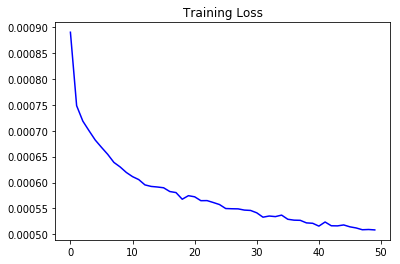

In [21]:
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(modelTrainer.metrics)

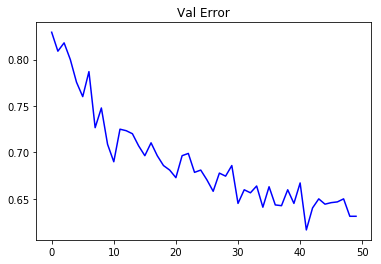

In [22]:
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.val_error for m in metrics], 'b')
    plt.title('Val Error')
    plt.show()

training_plot(modelTrainer.metrics)

In [23]:
modelTrainer.metrics[49].val_error

0.6310204081632653

In [0]:
test_data = SpectrogramTestDataset('11-785hw1p2-f19/', "test.npy", pre_padding=5, post_padding=5)



In [25]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=5000)

pred = []
for data in test_loader:
    X = Variable(data.view(-1, 440))
    out = modelTrainer.model(X)
    pred.append(out.data.max(1, keepdim=True)[1].cpu().numpy())
    #pred.append(out.data.max(1, keepdim=True)[1])
pred = np.concatenate(np.array(pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
import pandas as pd
df = pd.DataFrame(pred, columns=["label"])
df.to_csv('preds_model_21_9_24.csv', index_label = "id", index=True)

In [27]:
torch.save(modelTrainer.model, "model_21_9_24.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PhonemeModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# How to adjust Learning Rate

`torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update. See https://pytorch.org/docs/stable/optim.html for details.

In [0]:
def inference(model, loader, n_members):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, 440))
        Y = Variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct.numpy() / n_members

class Trainer():
    """ 
    A simple training cradle
    """
    
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def run(self, epochs):
        print("Start Training...")
        self.metrics = []
        for e in range(n_epochs):
            scheduler.step()
            epoch_loss = 0
            correct = 0
            for batch_idx, (data, label) in enumerate(train_loader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, 440))
                Y = Variable(label)
                out = self.model(X)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            total_loss = epoch_loss/train_size
            train_error = 1.0 - correct/train_size
            val_error = 1.0 - inference(self.model, val_loader, val_size)
            print("epoch: {0}, loss: {1:.8f}".format(e+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                  train_error=train_error,
                                  val_error=val_error))
         

In [0]:
### LET'S TRAIN ###

# A function to apply "normal" distribution on the parameters
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# We first initialize a Fashion Object and initialize the parameters "normally".
normalmodel = PhonemeModel()
normalmodel.apply(init_randn)

n_epochs = 100
'''
print("SGD OPTIMIZER")
SGDOptimizer = torch.optim.SGD(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(SGDOptimizer, step_size=0.01, gamma=0.1)
sgd_trainer = Trainer(normalmodel, SGDOptimizer)
sgd_trainer.run(n_epochs)
sgd_trainer.save_model('./sgd_model.pt')
print('')
'''

print("ADAM OPTIMIZER")
normalmodel = PhonemeModel()
normalmodel.apply(init_randn)
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(AdamOptimizer, step_size=4, gamma=0.1)
adam_trainer = Trainer(normalmodel, AdamOptimizer)
adam_trainer.run(n_epochs)
adam_trainer.save_model('./adam_model.pt')
print('')


print("RMSPROP OPTIMIZER")
normalmodel = PhonemeModel()
normalmodel.apply(init_randn)
RMSPropOptimizer = torch.optim.RMSprop(normalmodel.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(RMSPropOptimizer, step_size=4, gamma=0.1)
rms_trainer = Trainer(normalmodel, RMSPropOptimizer)
rms_trainer.run(n_epochs)
rms_trainer.save_model('./rmsprop_model.pt')
print('')


### TEST ###
model = PhonemeModel()
model.load_state_dict(torch.load('./sgd_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with SGD: {0:.2f}".format(test_acc * 100))

model = PhonemeModel()
model.load_state_dict(torch.load('./adam_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with Adam: {0:.2f}".format(test_acc * 100))

model = PhonemeModel()
model.load_state_dict(torch.load('./rmsprop_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with RMSProp: {0:.2f}".format(test_acc * 100))

In [0]:
model = PhonemeModel()
model.load_state_dict(torch.load('./rmsprop_model.pt'))

#value = torch.from_numpy(x_train[example_index])

# then put it on the GPU, make it float and insert a fake batch dimension
arrays = [array for array in train_data.X_test]
test_value = Variable(torch.from_numpy(np.concatenate(arrays)))
test_value = test_value.float()
test_value = test_value.unsqueeze(0)

# pass it through the model
prediction = model(test_value)

In [0]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(sgd_trainer.metrics)
training_plot(adam_trainer.metrics)
training_plot(rms_trainer.metrics)

## Parameter Initialization

While training a network, the initial value of the weights plays a significant role. In the extreme case, an oracle could just set the weights directly to values that minimize the objective function, and in practical cases a good initialization can bring us to a more favorable starting position in the parameter space. 

This raises the question of how to choose these weights. 

- What happens if all the weights are set to zero? The gradients become zero, and the network finds itself without a direction. 
- What if all of them are set to the same non-zero value? Although the gradients are no longer zero, each neuron has the same weight and follows the same gradient. Such neurons will continue to have the same value, since they're identical. 

So any initialization scheme must break this symmetry somehow, and randomly initializing the weights is a first step in that direction.

Let's begin with creating a weight initialization function that samples from **N(0,1)**. A clean way of initializing the weights is to access the network parameters by traversing all modules inside the network, and then applying the desired initialization. This method also allows us to encapsulate all the initializations into a single function.

In [0]:
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

Now let's use this scheme to initialize the network.

Note that *apply(fn)* applies the function *fn* recursively to every submodule (as returned by .children()) as well as self. Also, since it is applied to itself as well, you must take care to select the appropriate type of module *m* and apply the initialization to it.

In [0]:
normalmodel = FashionModel()
normalmodel.apply(init_randn)

## Custom initializations

We could also choose a different way to initialize the weights, where you explicitly copy some values into the weights.

In [0]:
def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

Now let's use this initialization scheme to implement Xavier initialization. 

Xavier initialization is a way of initializing the weights such that the variance of the inputs is the same as the variance of the outputs. At each layer, the fan_in and fan_out (i.e. input connections and output connections) might be different. To calculate the variance, you will multiply each weight with the inputs. Evidently, if the number of inputs is less, they will need to be multiplied with higher weights so that they can sum up to the product of a larger number of outputs with smaller weights. This is the intuition behind Xavier initialization.


In [0]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

In [0]:
xaviermodel = FashionModel()
xaviermodel.apply(init_xavier)

In [0]:
### LET'S TRAIN ###
n_epochs = 3

print("NORMAL INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.001)
normal_trainer = Trainer(normalmodel, AdamOptimizer)
normal_trainer.run(n_epochs)
normal_trainer.save_model('./normal_model.pt')
print('')


print("XAVIER INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(xaviermodel.parameters(), lr=0.001)
xavier_trainer = Trainer(xaviermodel, AdamOptimizer)
xavier_trainer.run(n_epochs)
xavier_trainer.save_model('./xavier_model.pt')
print('')

In [0]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(normal_trainer.metrics)
training_plot(xavier_trainer.metrics)

## Using pretrained weights

In the previous section we saw that initializations can start the training from a good spot. In addition to these schemes, you might also need to have specific methods to initialize the weights in different layers. For example, you might want to use a pretrained model like Alexnet to give your network a head start for visual recognition tasks. Let's load the pretrained Alexnet model and see how it works.

In [0]:
alexnet_model = models.alexnet(pretrained=True)

## Adding Momentum

We can make use of the `self.state` data-structure to maintain a copy of an accumulated gradient that we also decay at each step. Once again we use inplace operations to avoid unneccesary buffer allocation. Recall a standard update with momentum given decay rate $\mu$.

$$ \begin{align}
\textbf{V'} &= \mu \textbf{V} - \eta \nabla L(\textbf{W})\\
\textbf{W'} &= \textbf{W} + \textbf{V'}\\
\end{align}
$$

## Batch Normalization

Batch normalization is a relatively simple but significant improvement in training neural networks. In machine learning, *covariate shift* is a phenomenon in which the covariate distribution is non-stationary over the course of training. This is a common phenomenon in online learning. When training a neural network on a fixed dataset, there is no covariate shift (excluding sample noise from minibatch approximation), but the distribution of individual node and layer activity shifts as the network parameters are updated. As an abstraction, we can consider each node's activity to be a covariate of the following nodes in the network. Thus we can think of the non-stationarity of node (and layer) activations as a sort of *internal covariate shift*. 

Why is internal covariate shift a problem? Each subsequent layer has to account for a shifting distribution of its inputs. For saturating non-linearities the problem becomes even more dire, as the shift in activity will more likely place the unit output in the saturated region of the non-linearity.



In [0]:
class BatchNorm(nn.Module):

    def __init__(self, num_features):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.weight = Parameter(torch.Tensor(num_features))
        self.bias = Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def forward(self, x):
        pass

## Overfitting
Deep neural networks contain multiple non-linear hidden layers and this makes them very
expressive models that can learn very complicated relationships between their inputs and
outputs. With limited training data, however, many of these complicated relationships
will be the result of sampling noise, so they will exist in the training set but not in real
test data even if it is drawn from the same distribution. This leads to overfitting and many
methods have been developed for reducing it.

## Dropout
Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. The term "dropout" refers to dropping out units in a neural network.

## Regularization (weight_decay)

Weight decay specifies regularization in the neural network.
During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation.

As a rule of thumb, the more training examples you have, the weaker this term should be. The more parameters you have the higher this term should be.


In [0]:
class FashionModel_Tricks(nn.Module):
    
    def __init__(self):
        super(FashionModel_Tricks, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(self.bnorm1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(self.bnorm2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel_Tricks())

In [0]:
### TRAIN MODELS WITH BATCHNORM AND DROPOUT ###
n_epochs = 10

model = FashionModel_Tricks()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
btrainer = Trainer(model, optimizer)
btrainer.run(n_epochs)
btrainer.save_model('./dropout-batchnorm_optimized_model.pt')

training_plot(btrainer.metrics)

print('')

## Gradient Clipping

During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime or in a less extreme situation, the Model starts overshooting past our Minima; this issue is called the Gradient Explosion Problem.

Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large.

In [0]:
#Gradient Clipping 
# `clip_grad_norm` helps prevent the exploding gradient problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)

## Annealing Learning Rate
In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. One way of doing it is using step decay. Step decay schedule drops the learning rate by a factor every few epochs. The mathematical form of step decay is:

$$\eta = \eta_0 * drop^{\floor ( \frac{epoch}{epochs\_drop})}$$

In [0]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate